In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
df = pd.read_csv('emnist-balanced-train.csv', header=None)

df.head()
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
112795,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112796,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112798,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112799,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(112800, 785)

Plik z danymi zawiera 112800 danych o obrazach 28x28 pikseli (785 kolumn, 1. z nich jest etykietą obrazu). Etykiety te są numerami od 0 do 46 (47 łącznie: cyfry, duże i małe litery alfabetu angielskiego). Są one zmapowane w pliku emnist-balanced-mapping.txt

In [4]:
mapping = pd.read_csv('emnist-balanced-mapping.txt', delimiter=' ', header=None)
mapping_dict = {mapping.iloc[i, 0]: chr(mapping.iloc[i, 1]) for i in range(len(mapping))}

print(dict(list(mapping_dict.items())[20:30]))

{20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T'}


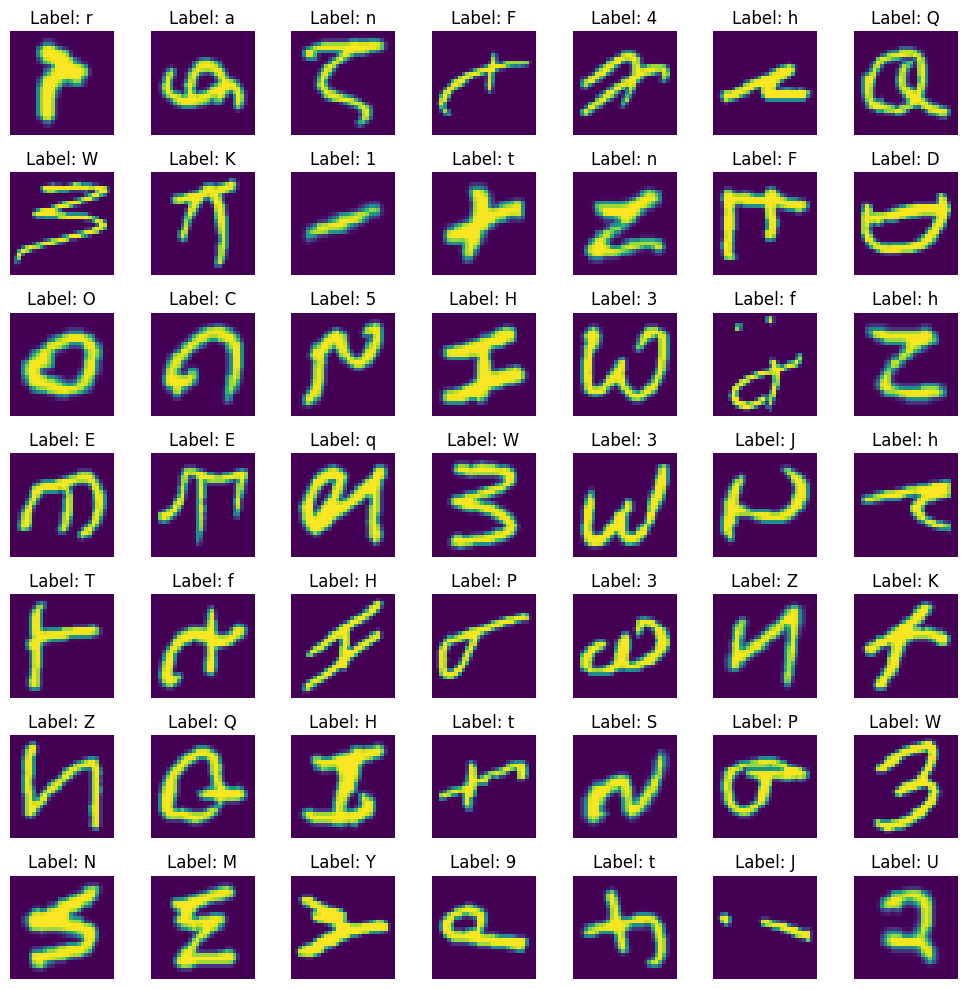

In [5]:
fig, axes = plt.subplots(7, 7, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = df.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Są odwrócone domyślnie, więc przekręcam je do pionu

In [6]:
for i in range(df.shape[0]):
    pixels = df.iloc[i,1:]
    
    image = pixels.values.reshape(28,28, 1).T
    pixels = image.flatten()
    
    df.iloc[i,1:] = pixels

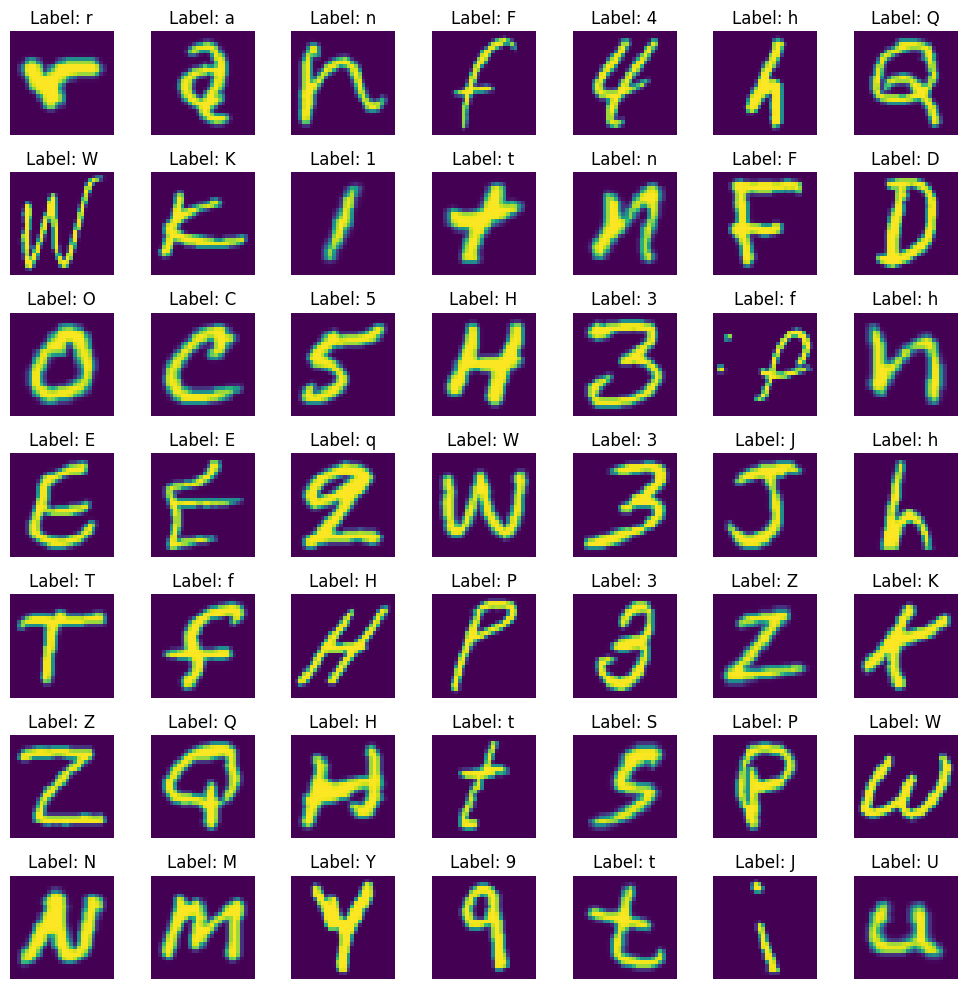

In [7]:
fig, axes = plt.subplots(7, 7, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    example = df.iloc[i, ]
    label = mapping_dict[example.iloc[0]]
    
    example = example[1:].values.reshape(28, 28)
    
    ax.imshow(example)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
print(df.iloc[:, 1:].max().max()) # kolor

255


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # sprawdzenie czy można szybciej

In [10]:
import torch.nn.functional as F
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.bn(x)
        x = self.drop(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = CNNBlock(1, 64, kernel_size=2, padding=1)
        self.layer2 = CNNBlock(64, 128, kernel_size=2, padding=1)
        self.layer3 = CNNBlock(128, 256, kernel_size=2, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, 47)
        
    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        x = self.layer3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
         
        return x

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split

X = df.iloc[:, 1:].values / 255.0
y = df.iloc[:, 0].values

class EMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype('float32')
        self.y = y.astype('int64')
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Updated: Normalization to 0.5 mean and std
        ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].reshape(28, 28)
        X = self.transform(X)
        y = self.y[idx]
        return X, y

In [12]:
dataset = EMNISTDataset(X, y)

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)


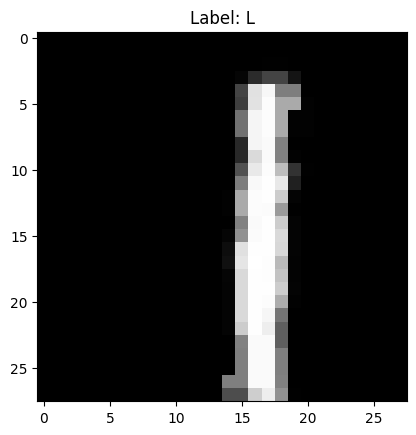

In [13]:
sampleX, sampley = next(iter(val_dataloader))

sampleX.shape, sampley.shape

image = sampleX[0].squeeze() #.permute(-2, -1)

plt.imshow(image, cmap='gray')
plt.title(f'Label: {mapping_dict[sampley[0].item()]}')
plt.show()

In [14]:
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scaler = GradScaler()

c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [15]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for inputs, labels in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast("cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        
        train_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / train_total)
    
    train_epoch_loss = train_loss / len(train_dataloader)
    train_epoch_accuracy = 100 * train_correct / train_total

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    
    with torch.no_grad():
        for inputs, labels in val_progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            val_progress_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / val_total)
    
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = 100 * val_correct / val_total

    # Print Epoch Summary
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")
    
    # Step the scheduler with validation loss
    scheduler.step(val_epoch_loss)

print("Finished Training")


Epoch 1/10 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

c:\Users\jedno\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/10, Train Loss: 2.7888, Train Accuracy: 31.01%, Val Loss: 3.1221, Val Accuracy: 16.37%


Epoch 2/10, Train Loss: 1.5995, Train Accuracy: 63.75%, Val Loss: 2.6702, Val Accuracy: 28.14%


Epoch 3/10, Train Loss: 1.0541, Train Accuracy: 73.93%, Val Loss: 1.6595, Val Accuracy: 50.81%


Epoch 4/10, Train Loss: 0.8283, Train Accuracy: 77.93%, Val Loss: 1.3014, Val Accuracy: 60.61%


Epoch 5/10, Train Loss: 0.7131, Train Accuracy: 80.13%, Val Loss: 1.1786, Val Accuracy: 64.38%


Epoch 6/10, Train Loss: 0.6454, Train Accuracy: 81.45%, Val Loss: 1.0102, Val Accuracy: 68.40%


Epoch 7/10, Train Loss: 0.5951, Train Accuracy: 82.35%, Val Loss: 0.8028, Val Accuracy: 74.77%


Epoch 8/10, Train Loss: 0.5599, Train Accuracy: 83.18%, Val Loss: 0.8310, Val Accuracy: 74.33%


Epoch 9/10, Train Loss: 0.5350, Train Accuracy: 83.59%, Val Loss: 0.7362, Val Accuracy: 77.11%


Epoch 10/10, Train Loss: 0.5163, Train Accuracy: 84.10%, Val Loss: 0.7266, Val Accuracy: 77.74%
Finished Training


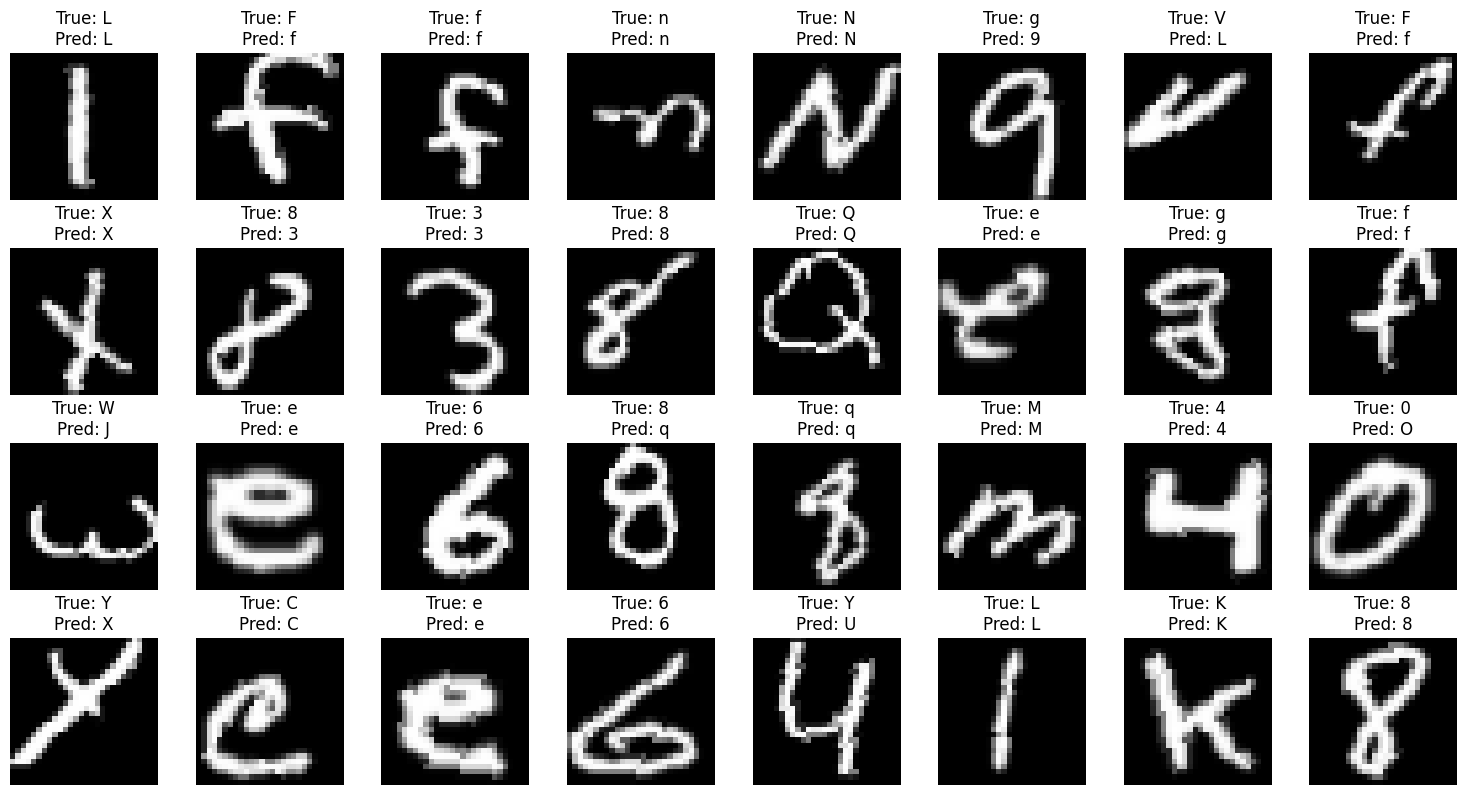

In [16]:

# Set the model to evaluation mode
model.eval()

# Get a batch of data from the dataloader
inputs, labels = next(iter(val_dataloader))

# Move the inputs and labels to the device
inputs, labels = inputs.to(device), labels.to(device)

# Perform the forward pass to get predictions
outputs = model(inputs)

# Get the predicted class
_, preds = torch.max(outputs, 1)

# Plot the images along with the true and predicted labels
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    img = inputs[i].cpu().numpy().squeeze()
    true_label = mapping_dict[labels[i].item()]
    pred_label = mapping_dict[preds[i].item()]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {true_label}\nPred: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
torch.save(model.state_dict(), 'model.pth')